In [2]:
import random
import math
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import sys
import numpy as np
import torch
import logomaker


sys.path.append('../../../Enhancer')  
from train.utils import EnhancerDataset, split_dataset, train_model, regression_model_plot, plot_filter_weight
import train.interpretation
import train.tools
from model.model import ExplaiNN3

In [3]:

def generate_random_dna(length, num_dna, motif, max_num_motif):
    """Generate random DNA sequences and calculate the motif distance score."""
    if max_num_motif < 0 or not isinstance(max_num_motif, int):
        raise ValueError("max_num_motif needs to be a positive integer")
    if (len(motif) + 4) * max_num_motif > length:
        raise ValueError('Length of motif * maximum occurance of motif is greater than DNA length')
    if len(motif) > length // 3:
        warnings.warn("Motif is longer than one-third of the DNA length.")
    
    dna_sequences = []
    scores = []
    proportion = {i: 0 for i in range(max_num_motif+1)}
    
    nucleotides = ['A', 'T', 'C', 'G']
    
    for i in range(num_dna):
        # Generate a random DNA sequence
        dna = ''.join(random.choices(nucleotides, k=length))
        
        # Decide randomly how many motifs to insert
        num_motif_insert = random.randint(0, max_num_motif)

        dna, score, num_insert = insert_motifs(dna, motif, num_motif_insert)
        dna_sequences.append(dna)
        scores.append(score)
        # Update the proportion dictionary with actual number of motifs inserted
        proportion[num_motif_insert] += 1
        if i%1000 == 0 or int(100*(i/(num_dna-1))) == 100:
            print(f'{int(100*(i/(num_dna-1)))}/100')
        

    return dna_sequences, scores, proportion


def insert_motifs(dna, motif, num_motif_insert):
    if num_motif_insert == 0:
        return dna, 0, 0
    dna_length = len(dna)
    motif_length = len(motif)
    index_list = list(range(dna_length - motif_length + 1))

    for i in range(num_motif_insert):
        if len(index_list) == 0:
            return dna, 5 * math.log10(i+1+1), i+1
        motif_index = random.choice(index_list)
        dna = dna[:motif_index] + motif + dna[motif_index + len(motif):]

        # Remove index that could cause motif overlapping from the index_list
        start = motif_index - len(motif) + 1
        end = motif_index + len(motif)
        index_list = [index for index in index_list if index < start or index >= end]
    return dna, 5 * math.log10(num_motif_insert+1), num_motif_insert


# Example usage
#dna_sequences, scores, portions = generate_random_dna(length=15, num_dna=50, motif='XXX', max_num_motif=2)
dna_sequences, scores, portions = generate_random_dna(length=608, num_dna=50000, motif='CCTTAAGGAGAGTCT', max_num_motif = 30 )

#print(dna_sequences)
#print(scores)
print(portions)

#df = pd.DataFrame({'sequence':dna_sequences, 'score': scores})
#df.to_pickle('/pmglocal/ty2514/Enhancer/Enhancer/data/Synthetic_Freq_Results/synthetic_freq_sequence.pl')


0/100
2/100
4/100
6/100
8/100
10/100
12/100
14/100
16/100
18/100
20/100
22/100
24/100
26/100
28/100
30/100
32/100
34/100
36/100
38/100
40/100
42/100
44/100
46/100
48/100
50/100
52/100
54/100
56/100
58/100
60/100
62/100
64/100
66/100
68/100
70/100
72/100
74/100
76/100
78/100
80/100
82/100
84/100
86/100
88/100
90/100
92/100
94/100
96/100
98/100
100/100
{0: 1616, 1: 1640, 2: 1610, 3: 1601, 4: 1600, 5: 1541, 6: 1674, 7: 1619, 8: 1713, 9: 1646, 10: 1606, 11: 1637, 12: 1651, 13: 1573, 14: 1653, 15: 1601, 16: 1519, 17: 1572, 18: 1593, 19: 1568, 20: 1641, 21: 1624, 22: 1574, 23: 1637, 24: 1634, 25: 1641, 26: 1624, 27: 1572, 28: 1592, 29: 1653, 30: 1575}


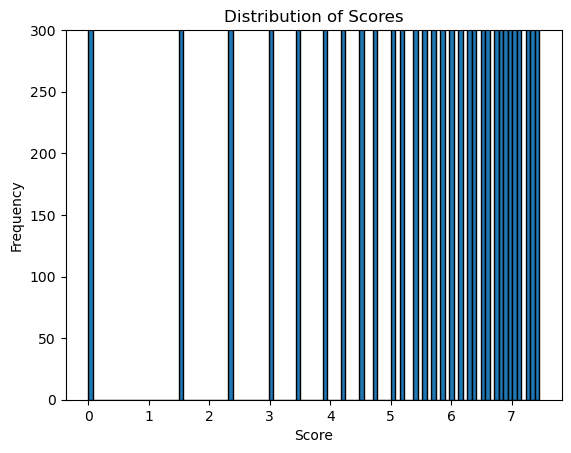

Using device: cuda
Model is on device: cuda:0
Epoch 1/200, Step 1/100, Loss: 34.8498
Epoch 1/200: Train Loss: 31.0564 , Test Loss: 27.4770
------------------------Evaluation------------------------
Label 1: MSE=27.4770, RMSE=5.2419, MAE=5.1085, R^2=-7.1252, Pearson=0.8471, Spearman=0.9493
Overall (Flattened): MSE=27.4770, RMSE=5.2419, MAE=5.1085, R^2=-7.1252, Pearson=0.8471, Spearman=0.9493
----------------------------------------------------------
Epoch 2/200, Step 1/100, Loss: 27.8416
Epoch 2/200: Train Loss: 25.6966 , Test Loss: 23.5041
------------------------Evaluation------------------------
Label 1: MSE=23.5041, RMSE=4.8481, MAE=4.7479, R^2=-5.9504, Pearson=0.8572, Spearman=0.9763
Overall (Flattened): MSE=23.5041, RMSE=4.8481, MAE=4.7479, R^2=-5.9504, Pearson=0.8572, Spearman=0.9763
----------------------------------------------------------
Epoch 3/200, Step 1/100, Loss: 23.7583
Epoch 3/200: Train Loss: 21.6891 , Test Loss: 20.3694
------------------------Evaluation-------------

In [4]:
# Define some hyperparameters
seed = 42
batch = 400
num_cnns = 90
learning_rate = 1e-4
target_labels = ['Motif Frequency Score']
output_dir = '/pmglocal/ty2514/Enhancer/Enhancer/data/Synthetic_Freq_Results/ExplaiNN_synthetic_freq_motif_results'


#df = pd.DataFrame({'sequence':dna_sequences, 'score': scores})
df = pd.read_pickle("/pmglocal/ty2514/Enhancer/Enhancer/data/Synthetic_Freq_Results/synthetic_freq_sequence.pl")
# Plot histogram of scores
plt.hist(df['score'], bins=100, edgecolor='black')
plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
#plt.ylim(0,300)
plt.show()

train, test = split_dataset(df, split_type='random', cutoff = 0.8, seed = seed)

train = EnhancerDataset(train, feature_list=['score'], scale_mode = 'none')
test = EnhancerDataset(test, feature_list=['score'], scale_mode = 'none')

# DataLoader setup
train_loader = DataLoader(dataset=train, batch_size=batch, shuffle=True)
test_loader = DataLoader(dataset=test, batch_size=batch, shuffle=True)

input_model = ExplaiNN3(num_cnns = num_cnns, input_length = 608, num_classes = 1, 
                 filter_size = 19, num_fc=2, pool_size=7, pool_stride=7, 
                 drop_out = 0.3, weight_path = None)# Training

_, _, model, train_losses_by_batch, test_losses_by_batch, results, best_pearson_epoch, best_r2_epoch, device  = train_model(input_model, train_loader, test_loader, 
                                                                                                                            target_labels=target_labels,num_epochs=200, 
                                                                                                                        batch_size=batch, learning_rate=learning_rate, 
                                                                                                                        criteria='mse',optimizer_type = "adam", patience=10, 
                                                                                                                        seed = seed, save_model= True, dir_path=output_dir)

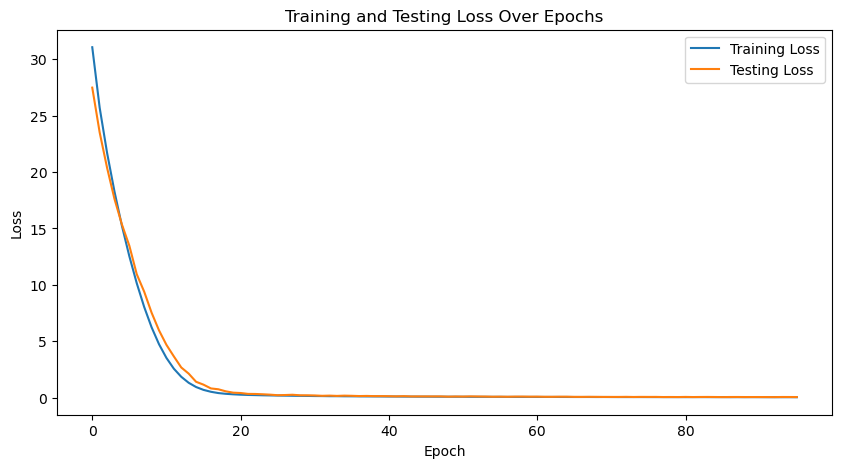

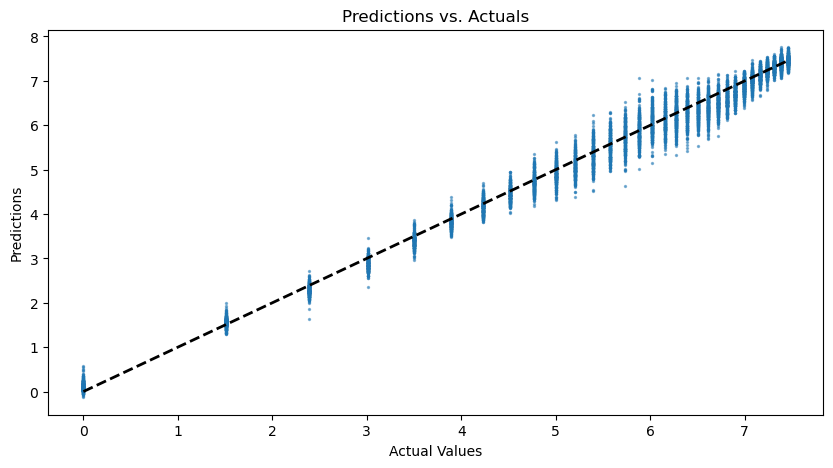

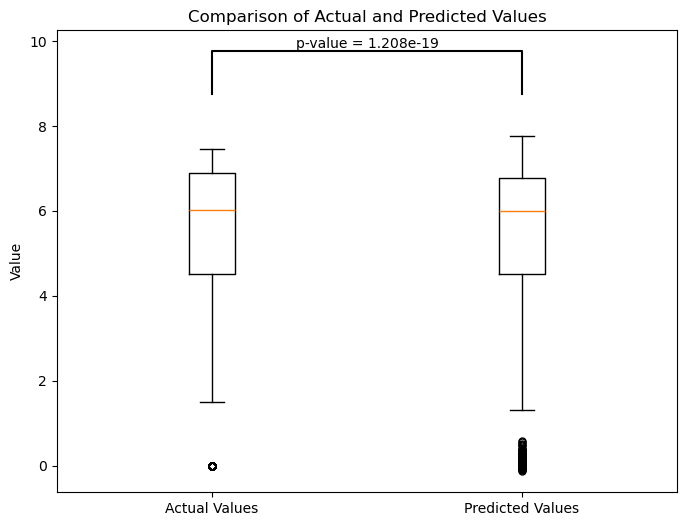

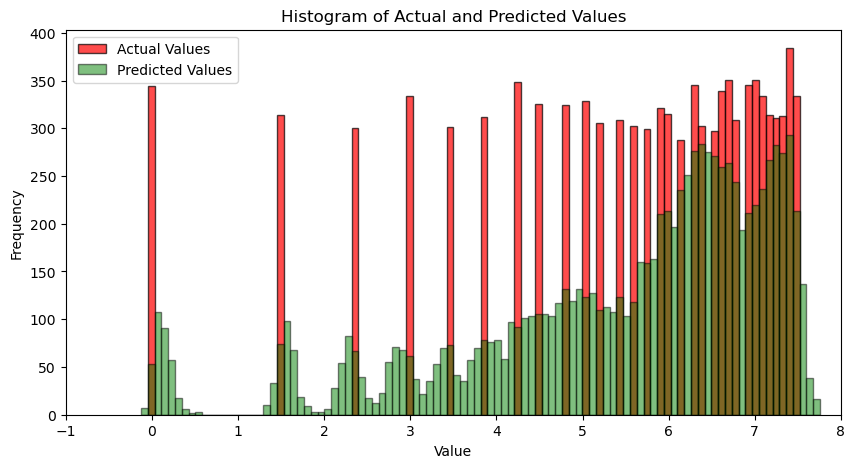

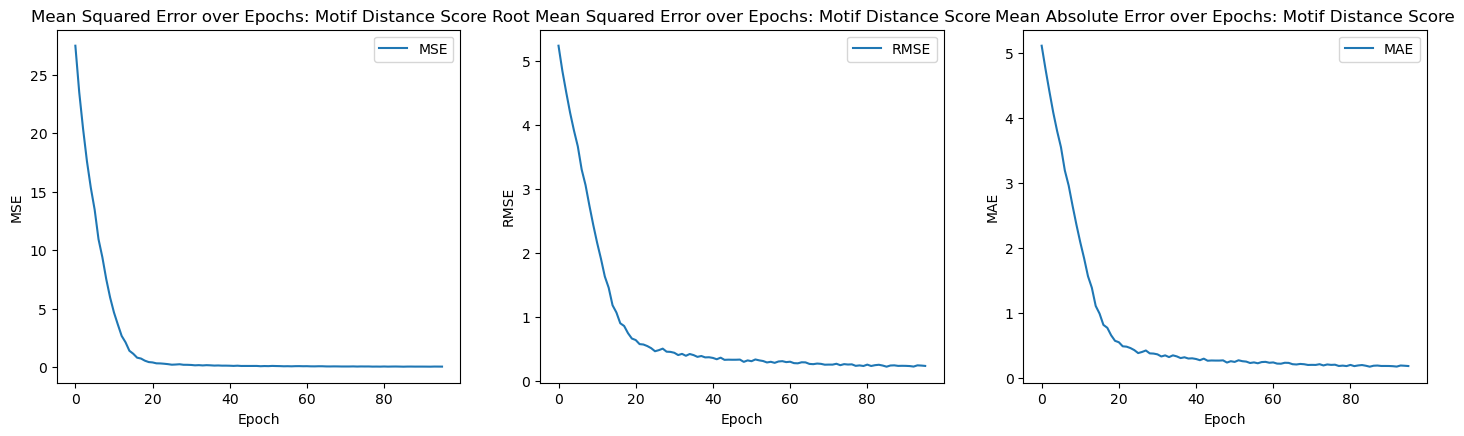

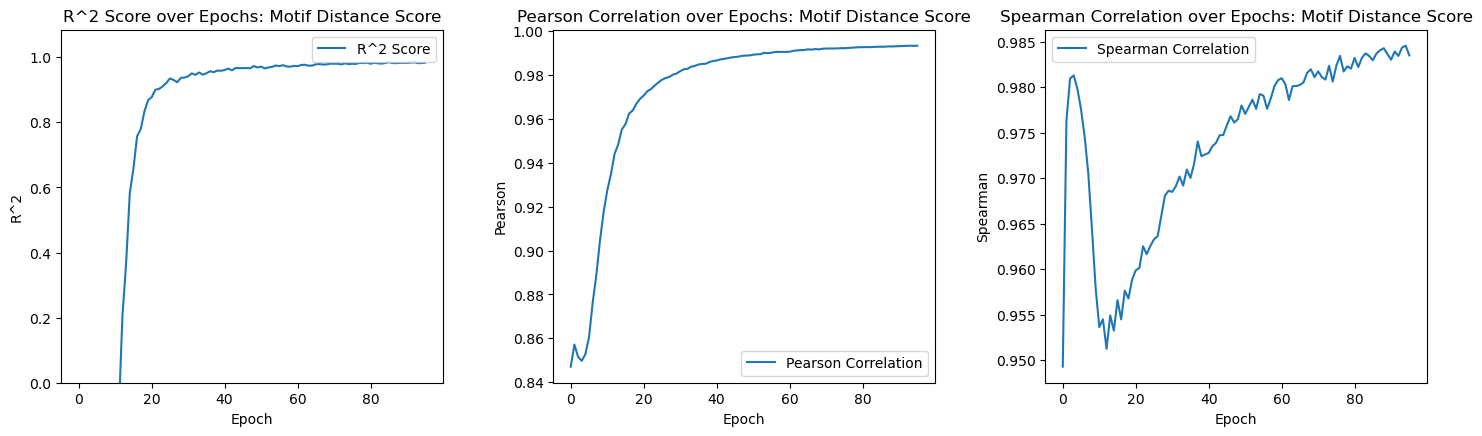

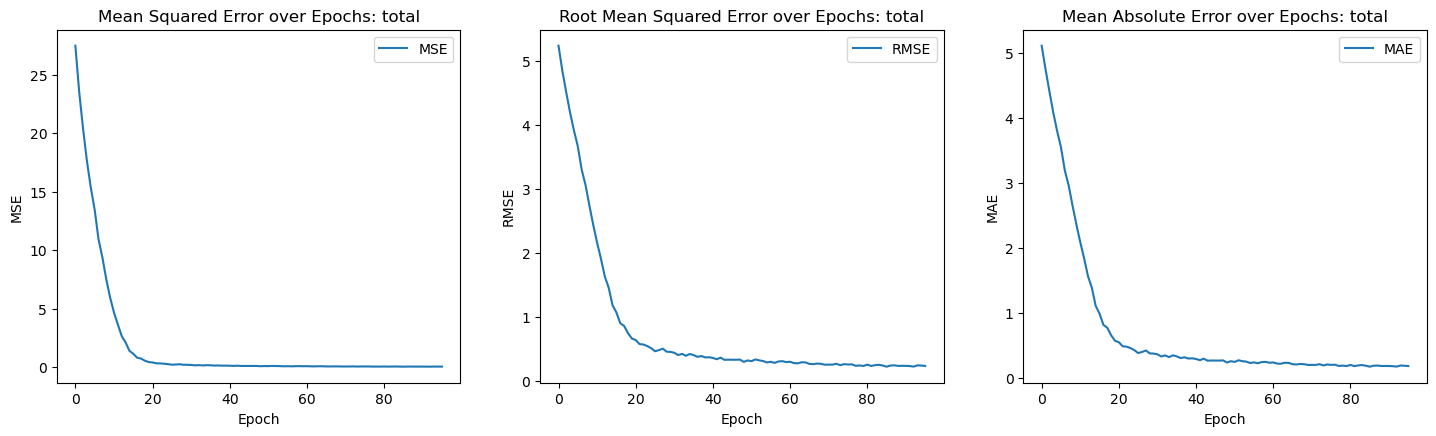

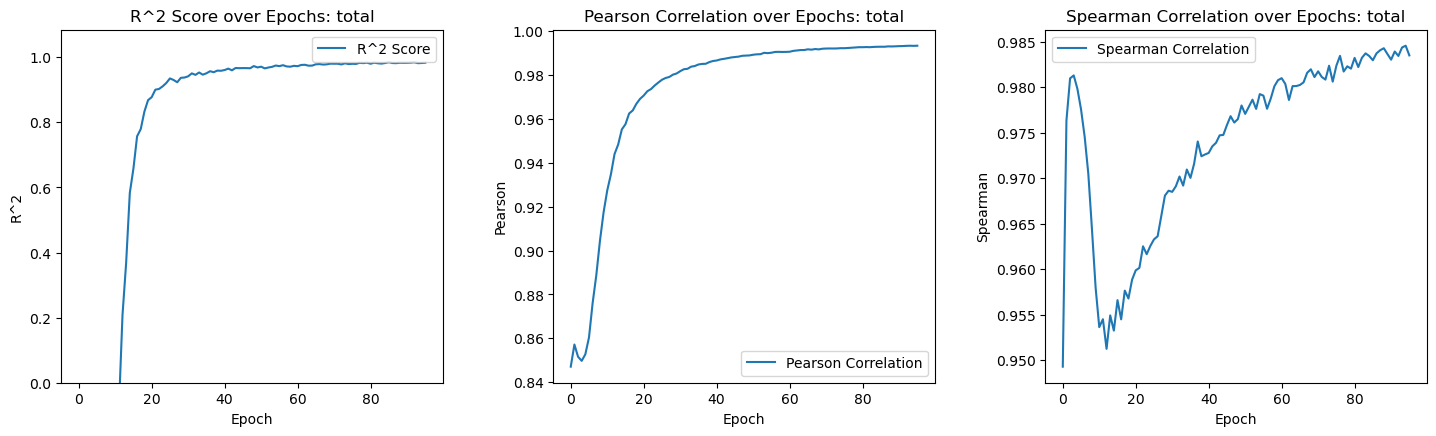

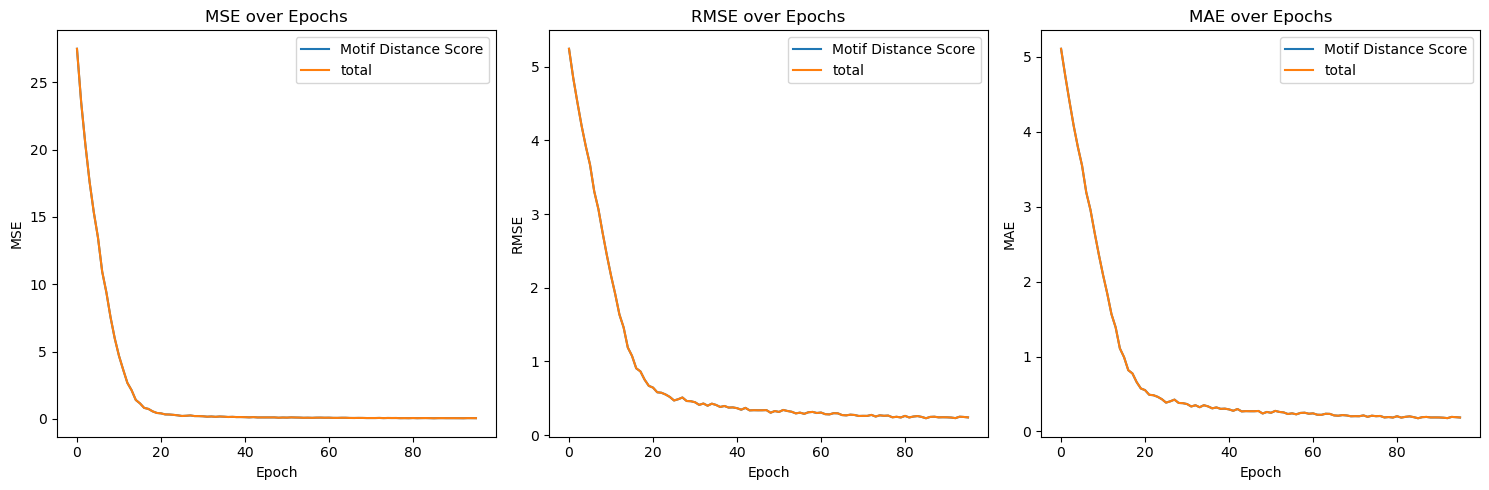

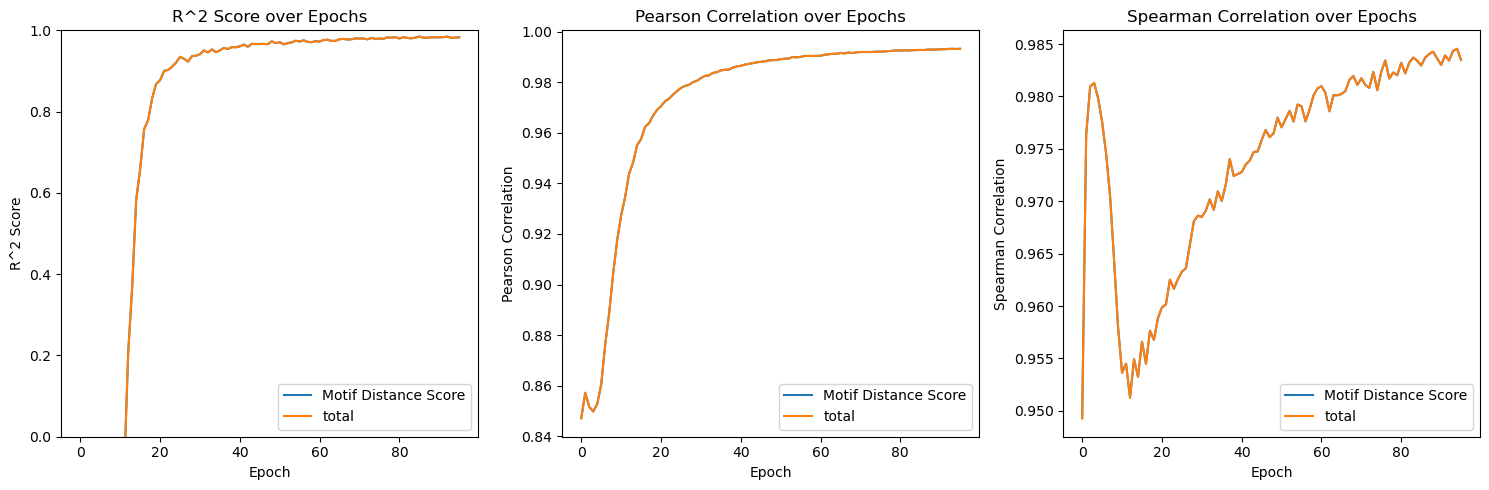

MSE: 0.0576, RMSE: 0.2401, MAE: 0.1860
R^2: 0.9830, Pearson Correlation: 0.9933, Spearman Correlation: 0.9835


In [5]:
#best_r2_epoch = 85

model_path = f'/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_synthetic_freq_motif_results/model_epoch_{best_r2_epoch}.pth'

mse, rmse, mae, r2, pearson_corr, spearman_corr = regression_model_plot(
    model, test_loader, train_losses_by_batch, test_losses_by_batch, 
    device, results, label_mode = "score", save_plot = False, dir_path = None, model_path = model_path, best_model=best_r2_epoch)

print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")
print(f"R^2: {r2:.4f}, Pearson Correlation: {pearson_corr:.4f}, Spearman Correlation: {spearman_corr:.4f}")

In [3]:
filter_size = 19
num_cnns = 90
filter_size = 19
best_r2_epoch = 85
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
explainn = ExplaiNN3(num_cnns = num_cnns, input_length = 608, num_classes = 1, 
                 filter_size = filter_size, num_fc=2, pool_size=7, pool_stride=7, 
                 drop_out = 0.3, weight_path = None)# Training
explainn.to(device)  

weight_file = f'/pmglocal/ty2514/Enhancer/Enhancer/data/Synthetic_Freq_Results/ExplaiNN_synthetic_freq_motif_results/model_epoch_{best_r2_epoch}.pth'
explainn.load_state_dict(torch.load(weight_file))
explainn.eval()

ExplaiNN3(
  (linears): Sequential(
    (0): Conv1d(360, 90, kernel_size=(19,), stride=(1,), groups=90)
    (1): BatchNorm1d(90, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ExpActivation()
    (3): MaxPool1d(kernel_size=7, stride=7, padding=0, dilation=1, ceil_mode=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Unsqueeze()
    (6): Conv1d(7560, 9000, kernel_size=(1,), stride=(1,), groups=90)
    (7): BatchNorm1d(9000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Dropout(p=0.3, inplace=False)
    (10): Conv1d(9000, 90, kernel_size=(1,), stride=(1,), groups=90)
    (11): BatchNorm1d(90, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Flatten(start_dim=1, end_dim=-1)
  )
  (final): Linear(in_features=90, out_features=1, bias=True)
)

In [4]:
batch = 400
df = pd.read_pickle("/pmglocal/ty2514/Enhancer/Enhancer/data/Synthetic_Freq_Results/synthetic_freq_sequence.pl")

dataset = EnhancerDataset(df, feature_list=['score'], scale_mode = 'none')
# Prepare dataloader
dataset = DataLoader(dataset=dataset, batch_size=batch, shuffle=False)

# Running get_explainn_predictions function to get predictions and true labels for all sequences in the given data loader
predictions, labels = train.interpretation.get_explainn_predictions(dataset, explainn, device, isSigmoid=False)
print(predictions.shape)

(50000, 1)


Number of samples before filtering: 50000
torch.Size([27558, 4, 608])
torch.Size([27558, 1])
Number of samples after filtering: 27558


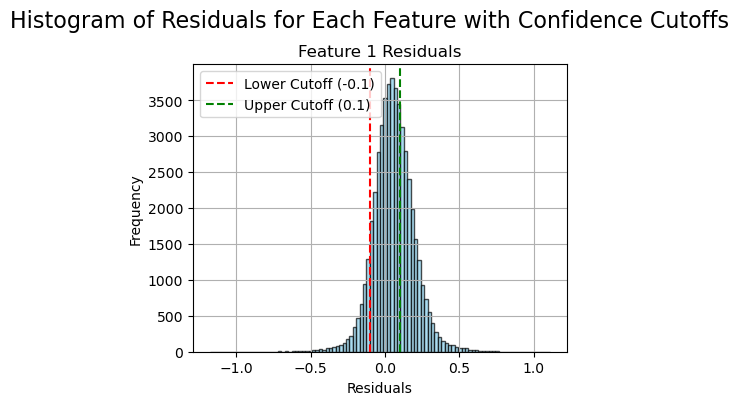

In [5]:
# Prepare features and labels:
# --(Features): Transform all sequences into one-hot encodings
# --(Labels): Use GFP+ and GFP- as labels
dataset = EnhancerDataset(df, feature_list=['score'], scale_mode = 'none')
# Prepare dataloader
dataset = DataLoader(dataset=dataset, batch_size=batch, shuffle=False)

# Running get_explainn_predictions function to get predictions and true labels for all sequences in the given data loader
predictions, labels = train.interpretation.get_explainn_predictions(dataset, explainn, device, isSigmoid=False)

"""Now filter out low confident predictions"""
# Calculate absolute residuals
residuals = np.abs(labels - predictions)

# Define the upper bound of residuals
upper_bound = 0.1

# Create a mask for filtering out samples with low confident precition (abs(residual) > upper_bound)
mask = (residuals <= upper_bound).all(axis=1)

# Get sequences and labels from dataset
data_inp = []
data_out = []
# Iterate over the DataLoader
for batch_features, batch_labels in dataset:
    data_inp.append(batch_features)
    data_out.append(batch_labels)
# Concatenate all the batches into single tensors
data_inp = torch.cat(data_inp, dim=0)
data_out = torch.cat(data_out, dim=0)

# Use the mask to filter the predictions and labels
print(f'Number of samples before filtering: {len(data_inp)}')
data_inp = data_inp[mask]
data_out = data_out[mask]
print(data_inp.shape)
print(data_out.shape)

print(f'Number of samples after filtering: {len(data_inp)}')

# Create new dataloader with filtered high confident samples
dataset = torch.utils.data.TensorDataset(data_inp, data_out)
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch, shuffle=False,)

# Plot histogram of residuals with adjusted cutoff lines
# 1. Compute residuals (not absolute)
residuals = labels - predictions

# 2. Define bounds for plotting
upper_bound = 0.1
lower_bound = -0.1

# 3.Plotting the histograms for each feature
fig, axes = plt.subplots(nrows=predictions.shape[1], ncols=1, figsize=(5, 4*predictions.shape[1]))
fig.tight_layout(pad=3.0)

# Title for the entire figure
fig.suptitle('Histogram of Residuals for Each Feature with Confidence Cutoffs', fontsize=16, y=1.02)

# Ensure axes is a list even if there's only one subplot
if predictions.shape[1] == 1:
    axes = [axes]

for i in range(predictions.shape[1]):
    ax = axes[i]
    ax.hist(residuals[:, i], bins=100, color='skyblue', edgecolor='black', alpha=0.7)
    ax.axvline(x=lower_bound, color='red', linestyle='--', label=f'Lower Cutoff ({lower_bound})')
    ax.axvline(x=upper_bound, color='green', linestyle='--', label=f'Upper Cutoff ({upper_bound})')
    ax.set_title(f'Feature {i+1} Residuals')
    ax.set_xlabel('Residuals')
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.grid(True)

plt.show()

In [5]:
""" ！！！！！！！！！！！！
You don't need to run this if you already calculated activations and pwms before
"""
# Get weights from activation layer
activations = train.interpretation.get_explainn_unit_activations(data_loader, explainn, device)
print(f"Activations have shape: {activations.shape}")
# Save activations
activation_path = '/pmglocal/ty2514/Enhancer/Enhancer/data/Synthetic_Freq_Results/90CNN_synthetic_freq_score_Activations.npy'
np.save(activation_path, activations)

# Get torch,  one-hot encoding sequences from data_loader
sequences = []
# Iterate over the DataLoader
for batch in data_loader:
    batch_sequences = batch[0]  
    sequences.append(batch_sequences)
sequences = torch.cat(sequences, dim=0)

# Define filter size. This parameter should be consistent with filter_size used in ExplaiNN
filter_size = 19
pwms = train.interpretation.get_pwms_explainn(activations, sequences, filter_size)

# Save pwms
pwm_path = '/pmglocal/ty2514/Enhancer/Enhancer/data/Synthetic_Freq_Results/90CNN_synthetic_freq_score_pwms.npy'
np.save(pwm_path, pwms)

100%|████████████████████| 69/69 [00:05<00:00, 11.62it/s]


Activations have shape: (27558, 90, 590)


100%|████████████████████| 90/90 [02:00<00:00,  1.34s/it]


In [6]:
pwm_path = '/pmglocal/ty2514/Enhancer/Enhancer/data/Synthetic_Freq_Results/90CNN_synthetic_freq_score_pwms.npy'
activation_path = '/pmglocal/ty2514/Enhancer/Enhancer/data/Synthetic_Freq_Results/90CNN_synthetic_freq_score_Activations.npy'
pwm_name = '/pmglocal/ty2514/Enhancer/Enhancer/data/Synthetic_Freq_Results/90CNN_synthetic_freq_score_TFBS.meme'
activations = np.load(activation_path)
print(f"Activations have shape: {activations.shape}")
pwms = np.load(pwm_path)
print(f"PWMs have shape: {pwms.shape}")
train.interpretation.pwm_to_meme(pwms, pwm_name)

Activations have shape: (27558, 90, 590)
PWMs have shape: (90, 4, 19)
Saved PWM File as : /pmglocal/ty2514/Enhancer/Enhancer/data/Synthetic_Freq_Results/90CNN_synthetic_freq_score_TFBS.meme


In [16]:
filter_anno = pd.read_csv('/pmglocal/ty2514/Enhancer/motif-clustering/bin/results/JASPAR2024_Filter_cluster.csv')
filtered_anno = filter_anno[filter_anno['source_id'].str.startswith('filter')]
filtered_anno

,Unnamed: 0,cluster,source_id,tf_name,family_name,motif_type,PMID,cluster_annotation
1,1,AC0002,filter20,filter20,Unknown,Unknown,Unknown,Unknown
6,6,AC0005,filter33,filter33,Unknown,Unknown,Unknown,Unknown
7,7,AC0006,filter11,filter11,Unknown,Unknown,Unknown,Unknown
8,8,AC0006,filter12,filter12,Unknown,Unknown,Unknown,Unknown
9,9,AC0006,filter13,filter13,Unknown,Unknown,Unknown,Unknown
...,...,...,...,...,...,...,...,...
236,236,AC0094,filter30,filter30,Unknown,Unknown,Unknown,Unknown
263,263,AC0102,filter49,filter49,Unknown,Unknown,Unknown,Unknown
264,264,AC0103,filter60,filter60,Unknown,Unknown,Unknown,Unknown
267,267,AC0105,filter51,filter51,Unknown,Unknown,Unknown,Unknown


In [25]:
# Step 2: Group by 'cluster' and annotate 'family_name'
def annotate_family_name(group):
    family_names = group['family_name']
    known_family_name = family_names[family_names != 'Unknown']
    
    if not known_family_name.empty:
        # If there is at least one known family name, use it to annotate the entire group
        group['family_name'] = known_family_name.iloc[0]
    
    return group

# Apply the function to each group
annotated_anno = filtered_anno.groupby('cluster').apply(annotate_family_name).reset_index(drop=True)

# Display the annotated DataFrame
annotated_anno['family_name'].value_counts()

/tmp/ipykernel_419187/4011075372.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  annotated_anno = filtered_anno.groupby('cluster').apply(annotate_family_name).reset_index(drop=True)


family_name
Unknown    90
Name: count, dtype: int64

In [8]:
tomtom_results = pd.read_csv("/pmglocal/ty2514/Enhancer/Enhancer/tomtom_all_db_results/tomtom_CAM_90NN_synthetic_freq_score/tomtom.tsv",
                                        sep="\t",comment="#")
filters_with_min_q = tomtom_results.groupby('Query_ID').min()["q-value"]
tomtom_results = tomtom_results[["Target_ID", "Query_ID", "q-value"]]
tomtom_results = tomtom_results[tomtom_results["q-value"]<0.05]
cisbp_motifs = {}
#with open("/pmglocal/ty2514/Enhancer/ExplaiNN/data/JASPAR/JASPAR2024_CORE_vertebrates_non-redundant_pfms_meme.txt") as f:
with open("/pmglocal/ty2514/Enhancer/ExplaiNN/data/JASPAR/all.dbs.meme") as f:
    for line in f:
        if "MOTIF" in line:
            motif = line.strip().split()[-1]
            name_m = line.strip().split()[-2]
            cisbp_motifs[name_m] = motif

filters = tomtom_results["Query_ID"].unique()
annotation = {}
for f in filters:
    t = tomtom_results[tomtom_results["Query_ID"] == f]
    target_id = t["Target_ID"]

    if len(target_id) > 5:
       target_id = target_id[:5]

    ###!!!!!!!!!!!!!
    target_id = target_id[:1]  ### If you only want to keep the most significant target_id, keep this line

    # Join Unique annotations by '/'
    ann = "/".join({cisbp_motifs[i]: i for i in target_id.values})
    annotation[f] = ann

annotation = pd.Series(annotation)
annotation

FileNotFoundError: [Errno 2] No such file or directory: '/pmglocal/ty2514/Enhancer/Enhancer/tomtom_all_db_results/tomtom_CAM_90NN_synthetic_freq_score/tomtom.tsv'

In [10]:
weights = explainn.final.weight.detach().cpu().numpy()
print(weights.shape)
num_cnns = 90
filters = ["filter"+str(i) for i in range(num_cnns)]
annotated_filters = ["filter"+str(i) for i in range(num_cnns)]

target_labels = ["Motif Distance Score"]

for i in annotation.keys():
    annotated_filters[int(i.split("filter")[-1])] = annotation[i]

weight_df = pd.DataFrame(weights, target_labels, columns=annotated_filters)
filters_df = pd.DataFrame([filters], index=["filters"], columns=annotated_filters)

# Concatenating the two DataFrames
weight_df = pd.concat([weight_df, filters_df])
weight_df.shape
weight_df

(1, 90)


,Tfcp2l1,filter1,filter2,CTCF,CTCF,filter5,CTCF,CTCF,filter8,Sox17,...,PPARA::RXRA,CTCF,filter82,CTCF,ZNF354A,filter85,CTCF,CTCF,filter88,ZNF354A
Motif Distance Score,-0.013128,0.016479,-0.012327,0.012878,-0.012944,0.02563,-0.014482,-0.014222,0.018306,0.010515,...,-0.013649,-0.011525,-0.014899,0.013946,0.014935,-0.014847,-0.010904,-0.012792,0.123328,-0.013331
filters,filter0,filter1,filter2,filter3,filter4,filter5,filter6,filter7,filter8,filter9,...,filter80,filter81,filter82,filter83,filter84,filter85,filter86,filter87,filter88,filter89


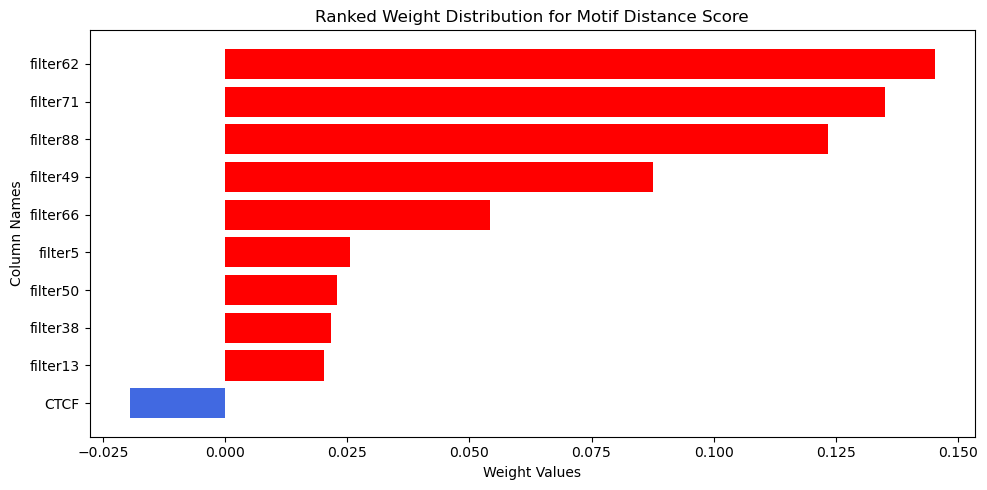

In [11]:
### Plot Bar Plots of Filter Weight Values
plot_filter_weight(weight_df, top_n=10)

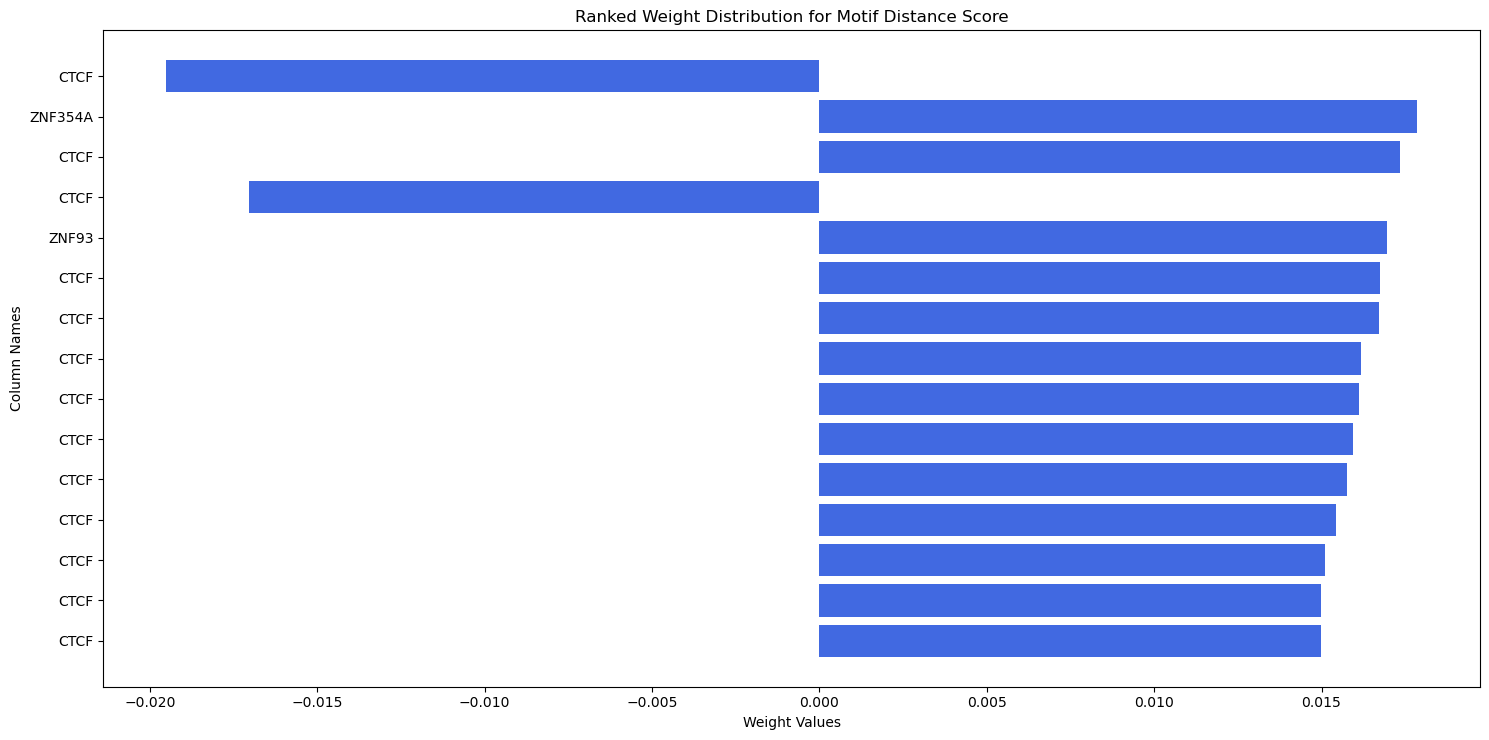

In [12]:
# Remove columns that does not have annotations
ann_wdf = weight_df.loc[:,["filter" not in i for i in list(weight_df)]]

plot_filter_weight(ann_wdf, top_n=15)

In [13]:
# Assuming 'interpretation' and 'explainn' are already defined and properly configured
# Also assuming 'data_loader', 'device', and 'annotation' are defined as per your setup

unit_importance_GFP_pos = []
unit_importance_GFP_neg = []
unit_importance_motif_dist_score = []
unit_names = []
unit_filters = []

# Loop through units with indices 0 to 4
for unit_index in range(num_cnns):
    filter_key = "filter" + str(unit_index)
    title = annotation[filter_key] if filter_key in annotation.index else filter_key
    unit_names.append(title)  # Store the unit name for plotting
    unit_filters.append(filter_key) # Store the filter name of each unit for presenting top important filters and motif logo plotting
    
    # Calculate unit importance for the current unit
    unit_outputs = interpretation.get_explainn_unit_outputs(data_loader, explainn, device)
    importance = interpretation.get_specific_unit_importance(activations, explainn, unit_outputs, unit_index, target_labels)
    unit_importance_motif_dist_score.append(importance['Motif Distance Score'])

('filter62', 'filter71', 'filter88', 'filter49', 'filter50', 'filter38', 'filter66', 'filter5', 'filter25', 'filter83')


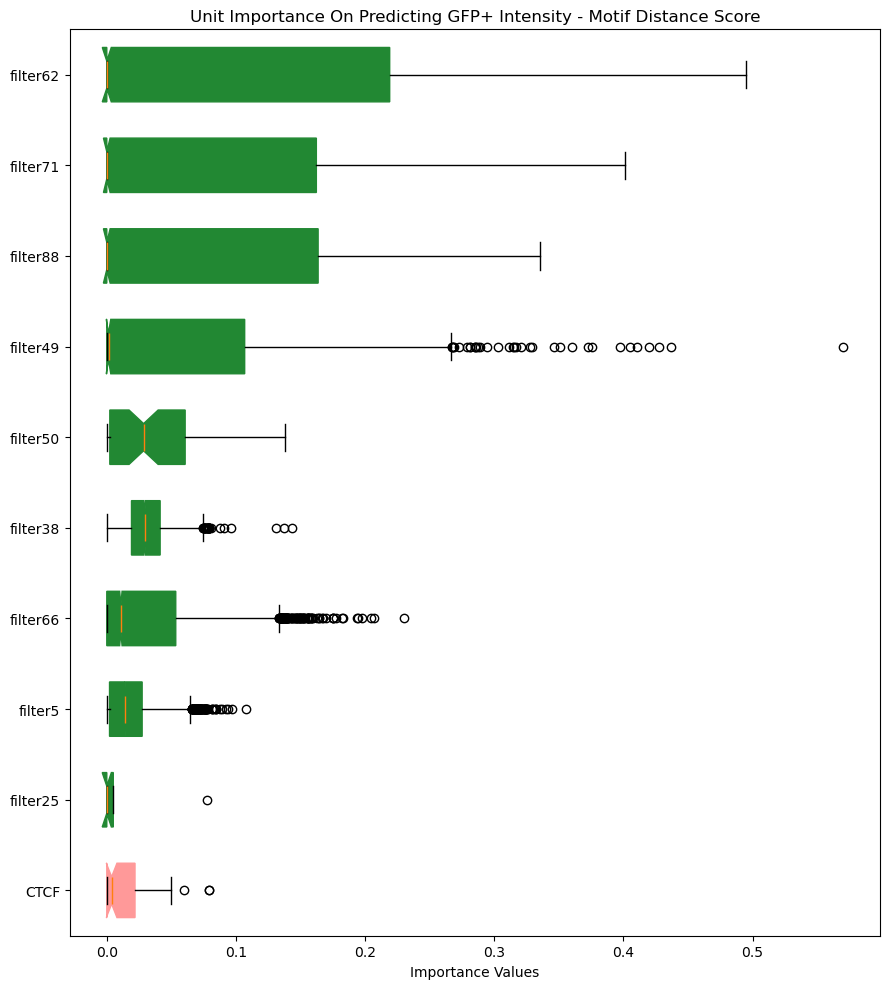

In [14]:
"""Plot the Ranked Importance Value of Each Filter"""
num_filter_plot = 10
# Create a list to store common important filters
common_filters = []

def plot_importance(ax, unit_importance_values, num_filter_plot, title_suffix):
    # Calculate the means of each list in unit_importance_values
    means = [np.mean(values) for values in unit_importance_values]

    # Create tuples of means, unit names, and values, then sort them by means
    sorted_data = sorted(zip(means, unit_names, unit_filters, unit_importance_values), key=lambda x: x[0], reverse=True)

    # Unzip the sorted data
    sorted_means, sorted_names, sorted_filters, sorted_values = zip(*sorted_data)

    # Print top 10 most impoertant filters
    print(sorted_filters[:num_filter_plot])

    # Unzip the sorted data
    sorted_means, sorted_names, sorted_filters, sorted_values = zip(*sorted_data[:num_filter_plot][::-1])

    # Define properties for outliers (fliers)
    flierprops = dict(marker='o', color='black', markersize=6)

    # Create box plots individually to control colors
    box_width = 0.6  # Set box width
    for i, (name, data) in enumerate(zip(sorted_names, sorted_values)):
        color = "#ff9999" if "filter" not in name.lower() else "#228833"
        ax.boxplot(data, positions=[i + 1], widths=box_width, notch=True, patch_artist=True,vert=False,
                   boxprops=dict(facecolor=color, color=color), flierprops=flierprops)

    # Set custom sorted x-axis labels
    ax.set_yticks(range(1, len(sorted_names) + 1))
    ax.set_yticklabels(sorted_names, rotation=0)
    ax.set_title(f"Unit Importance On Predicting GFP+ Intensity - {title_suffix}")
    ax.set_xlabel("Importance Values")

# Create a single plot
fig, ax = plt.subplots(figsize=(9, 10))

# Plot for Motif Distance Score
plot_importance(ax, unit_importance_motif_dist_score, num_filter_plot, "Motif Distance Score")

plt.tight_layout()
plt.show()



In [15]:
def get_specific_unit_importance(activations, model, unit_outputs, filt, target_labels):
    """
    Function to compute unit importance (unit_output*class weight) of a particular ExplaiNN unit (indexed at filt)
    :param activations: numpy.array, matrix of activations of shape (N, U, S); N - size of the dataset;
    U - number of units; S - size of the activation map
    :param model: ExplaiNN model
    :param unit_outputs: numpy.array, outputs of individual units, shape (N, U); N - size of the dataset; U - number of units;
    :param filt: int, index of the unit of interest;
    :param target_labels: a list with the names of the output nodes;
    :return: pandas.Series, contains O keys (number of ExplaiNN outputs, labels), each key contains an array of size X,
    where X is equal to the number of sequences that activated the unit of interest (indexed at filt) more than an
    activation threshold
    """

    activation_threshold = 0.5 * np.amax(activations, axis=(0, 2))
    print(f"activation_threshold shape: {activation_threshold.shape}")
    print(f"activation shape: {activations.shape}")

    # sequences (their indeces) that highly activated the filter
    res = {}
    for i in range(activation_threshold.shape[0]):
        if i != filt: continue # focus on current unit
        inds = []
        print(f"current filter is filter{filt}")
        for j in range(activations.shape[0]):
            # For 590 features at jth sample in the ith cnn, find indices of features that are activated 
            indices = np.where(activations[j, i, :] > activation_threshold[i])
            if indices[0].shape[0] > 0:
                inds.append(j)
        res[i] = inds # inds contains index of samples that have at least 1 activated feature among 590 in the specified cnn filter
    

    weights = model.final.weight.detach().cpu().numpy()  # -0.035227 0.480355
    print(f"weights shape {weights.shape}")

    res_distr = {}
    for cl in range(len(target_labels)):
        # 
        f_cell = np.multiply(unit_outputs, weights[cl])
        print(f'For label {target_labels[cl]}')
        print(f'final cell shape after multiplying cnn outputs [sample, num_cnn] with weight [1, num_cnn]: {f_cell.shape}')
        res_distr[target_labels[cl]] = f_cell[:, filt]
        print(f'interested filter final cell shape" {res_distr[target_labels[cl]].shape}')
        print(f'interested filter final cell sum" {np.sum(res_distr[target_labels[cl]])}')
        res_distr[target_labels[cl]] = res_distr[target_labels[cl]][res[filt]]
        print(f'After removing samples dont have any activated features: {res_distr[target_labels[cl]].shape}')

    res_distr = pd.Series(res_distr)

    return res_distr
# unit_outputs are the output 90 feature values for each sample from ExplaiNN linears layer (before final layer) 
unit_outputs = interpretation.get_explainn_unit_outputs(data_loader, explainn, device)
print(unit_outputs.shape)
target_labels = ['Motif Distance Score']
importance = get_specific_unit_importance(activations, explainn, unit_outputs, 55, target_labels)
print(f'importance shape: {importance.shape}')
importance

(13825, 90)


activation_threshold shape: (90,)
activation shape: (13825, 90, 590)
current filter is filter55
weights shape (1, 90)
For label Motif Distance Score
final cell shape after multiplying cnn outputs [sample, num_cnn] with weight [1, num_cnn]: (13825, 90)
interested filter final cell shape" (13825,)
interested filter final cell sum" -50.46660614013672
After removing samples dont have any activated features: (99,)
importance shape: (1,)


Motif Distance Score    [-0.012256238, -0.027120681, -0.0020398104, -0...
dtype: object

filter not annotated
filter not annotated
filter not annotated
filter not annotated
filter not annotated
filter not annotated
filter not annotated
filter not annotated
filter not annotated
CTCF


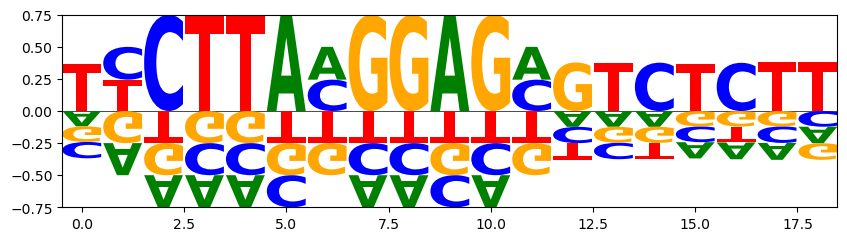

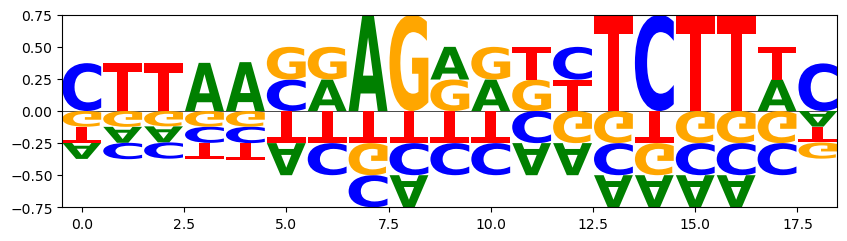

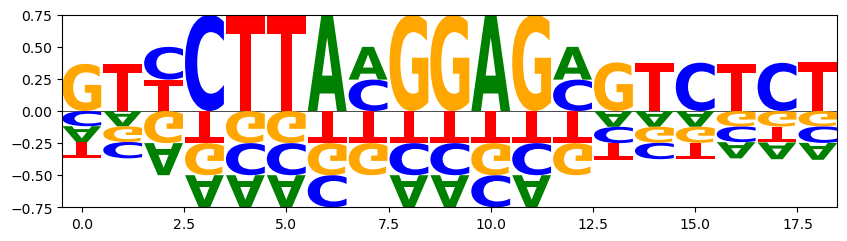

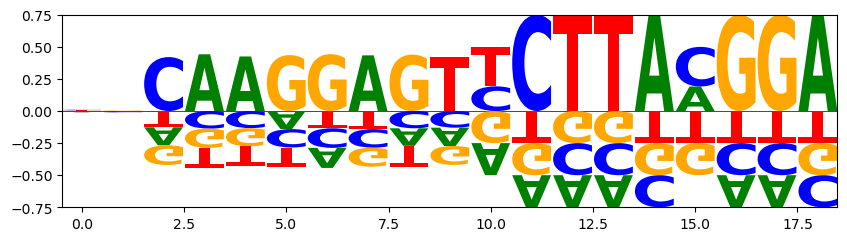

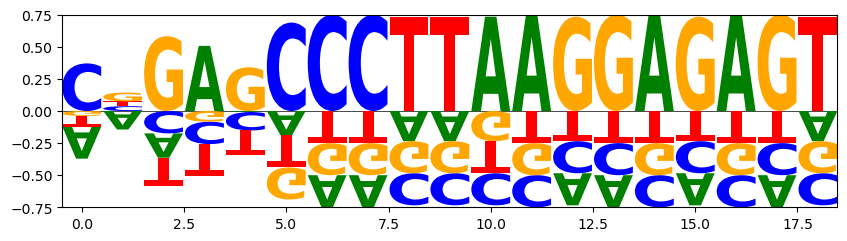

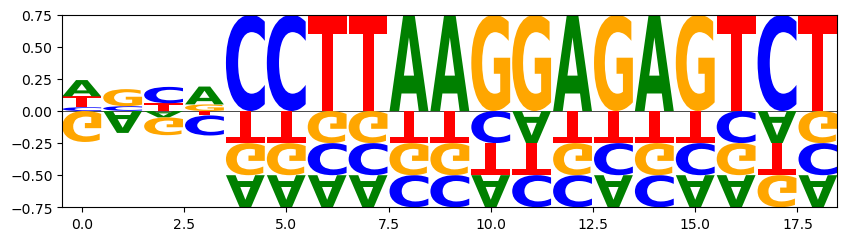

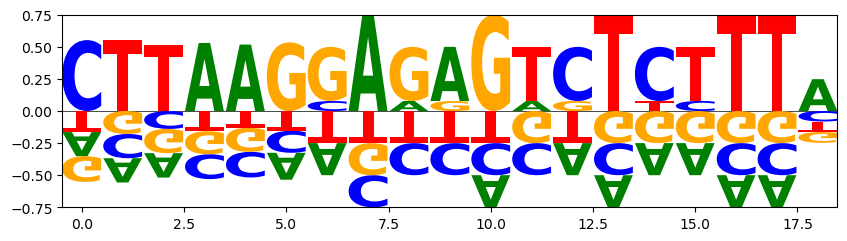

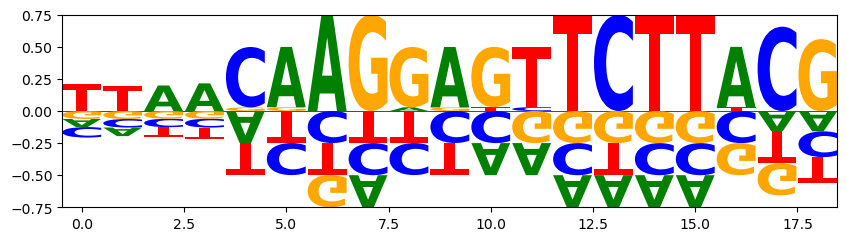

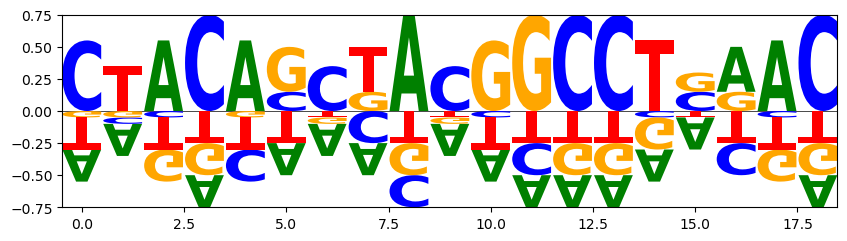

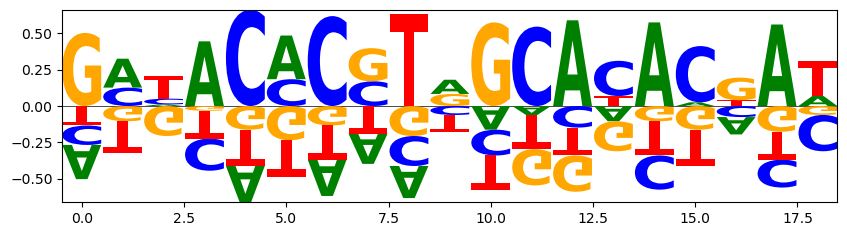

In [16]:
# Generate Motif Logos for top important filter PWMs
motifs, motif_names = tools.read_meme('/pmglocal/ty2514/Enhancer/Enhancer/data/90CNN_synthetic_score_TFBS.meme')

filterid=62
# motifA='CCTTAAGGAGAGTCTCTTT', motifB='CAAGGAGTTCTTACGGAGC'
# For distance score prediction: ('filter62', 'filter71', 'filter88', 'filter49', 'filter50', 'filter38', 'filter66', 'filter5', 'filter25', 'filter83')
for filterid in [62,71,88,49,50,38,66,5,25,83]:
    x = [list(i) for i in motifs[filterid]]
    pwm = tools._PWM_to_filter_weights(x, filter_size)
    nn_logo = logomaker.Logo(pd.DataFrame(data=pwm,columns = ["A","C", "G","T"]))
    if ('filter' + str(filterid)) in annotation:
        print(annotation['filter' + str(filterid)])
    else:
        print("filter not annotated")